### Import Modules

In [4]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # graphs
import matplotlib.pyplot as plt  # plots


Read in the datasets

In [5]:
data_filename = './Chess2021.csv'
data = pd.read_csv(data_filename, parse_dates=True, index_col='Unnamed: 0')

eco_filename = './chess-eco-reference.csv'
eco = pd.read_csv(eco_filename)


### Data Wrangling

In [6]:

# Drop the games where Movetext is Nan. No moves
data.dropna(subset=['Movetext'], inplace=True)

# Append a ECO_Name column in the data This also gives us a chance to further disect the A00 uncommon openings according to the moves played.
data['ECO_Name'] = data.ECO.apply(
    lambda x: eco[eco['ECO Code'] == x].Name.values[0])


# Create a dict of moves and names of Uncommon Openings
eco_a00_moves = ['1. b4', '1. g3', '1. g4', '1. h3', '1. h3 e5 2. a3', '1. Nh3', '1. Nc3', '1. Nc3 e5 2. a3', '1. Nc3 c5 2. d4 cxd4 3. Qxd4 Nc6 4. Qh4', '1. a3', '1. a4',
                 '1. a4 e5 2. h4', '1. c3', '1. d3', '1. d3 e5 2. Nd2', '1. d3 c5 2. Nc3 Nc6 3. g3', '1. e3', '1. e3 e5 2. c4 d6 3. Nc3 Nc6 4. b3 Nf6', '1. f3', '1. f3 e5 2. Kf2',
                 '1. h4', '1. Na3', '1. e4 d5', '1. Nf3 Nf6', '1. Nf3 c5']
eco_a00_names = ['Polish Opening', 'Benko\'s Opening', 'Grob\'s Attack', 'Clemenz Opening', 'Global Opening', 'Amar Opening',
                 'Dunst Opening', 'Battambang Opening', 'Novosibirsk Opening', 'Anderssen\'s Opening',  'Ware Opening',
                 'Crab Opening', 'Saragossa Opening', 'Mieses Opening', 'Valencia Opening', 'Venezolana Opening', 'Van\'t Kruijs Opening',
                 'Amsterdam Attack', 'Gedutt\'s Opening', 'Hammerschlag Opening', 'Anti-Borg Opening', 'Durkin\'s Attack', 'Scandanavian Defense', 'Indian Defense', 'Reti Opening']

eco_a00_dict = dict(zip(eco_a00_moves, eco_a00_names))

# Update the names which are currently 'Uncommon Opening' to the correct name

def get_eco_a00_name(x):
    name = x.ECO_Name

    for each in eco_a00_dict.keys():
        if each in x.Movetext:
            name = eco_a00_dict[each]

    return name


data.ECO_Name = data.apply(get_eco_a00_name, axis=1)
data.ECO_Name.value_counts()


Queen's Pawn Game                                       9517
Sicilian                                                5547
Dunst Opening                                           4150
Anti-Borg Opening                                       4147
Grob's Attack                                           3633
                                                        ... 
Queen's Gambit Declined, Orthodox Defense, Classical       1
Benoni, Classical with ...a6 and 10...Bg4                  1
Catalan, Open                                              1
King's Indian, Orthodox, Taimanov                          1
Benoni, Four Pawns Attack                                  1
Name: ECO_Name, Length: 313, dtype: int64

### Is there a opening which has the more wins for a particular color?

Text(0, 0.5, 'Count')

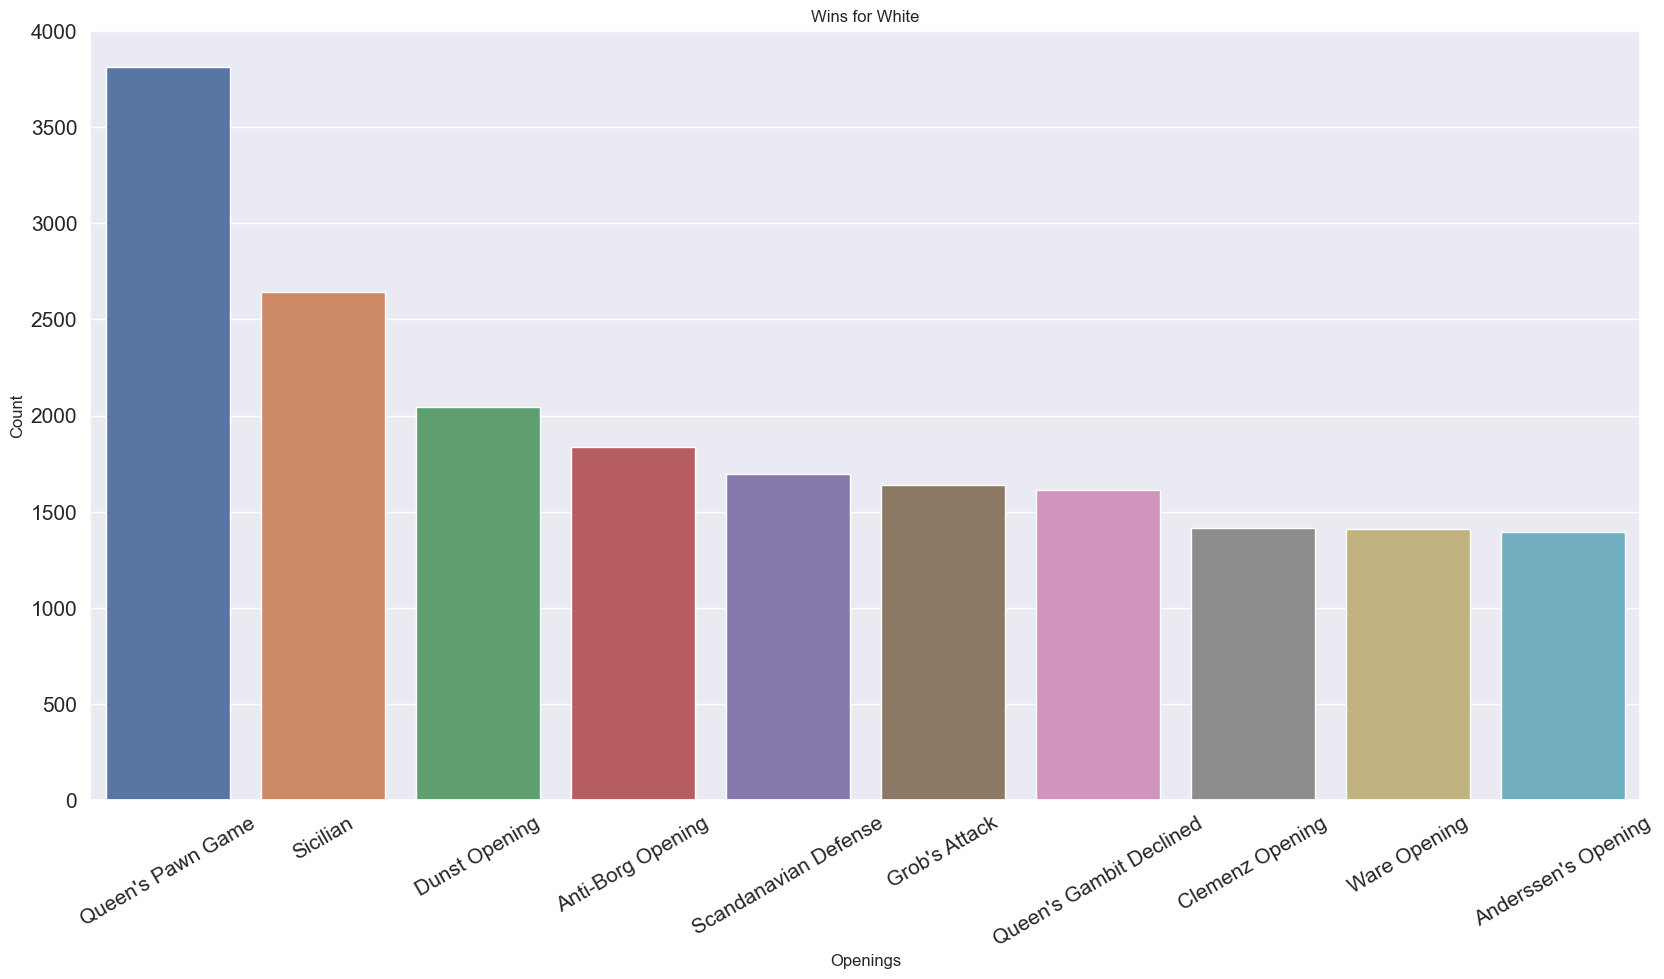

In [7]:
# Get the rows with Result '1-0' since it indicates white win and limit it to first 10.
# For black get rows with Resul '0-1'
top_10_white_wins = data[data.Result == '1-0'].ECO_Name.value_counts()[:10]

sns.set(rc={"figure.figsize": (20, 10)})
sns.barplot(x=top_10_white_wins.index,
            y=top_10_white_wins.values, orient='vertical')
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Wins for White')
plt.xlabel('Openings')
plt.ylabel('Count')

### Is there a preferred opening for the type of Event?

Text(0.5, 0, 'Opening')

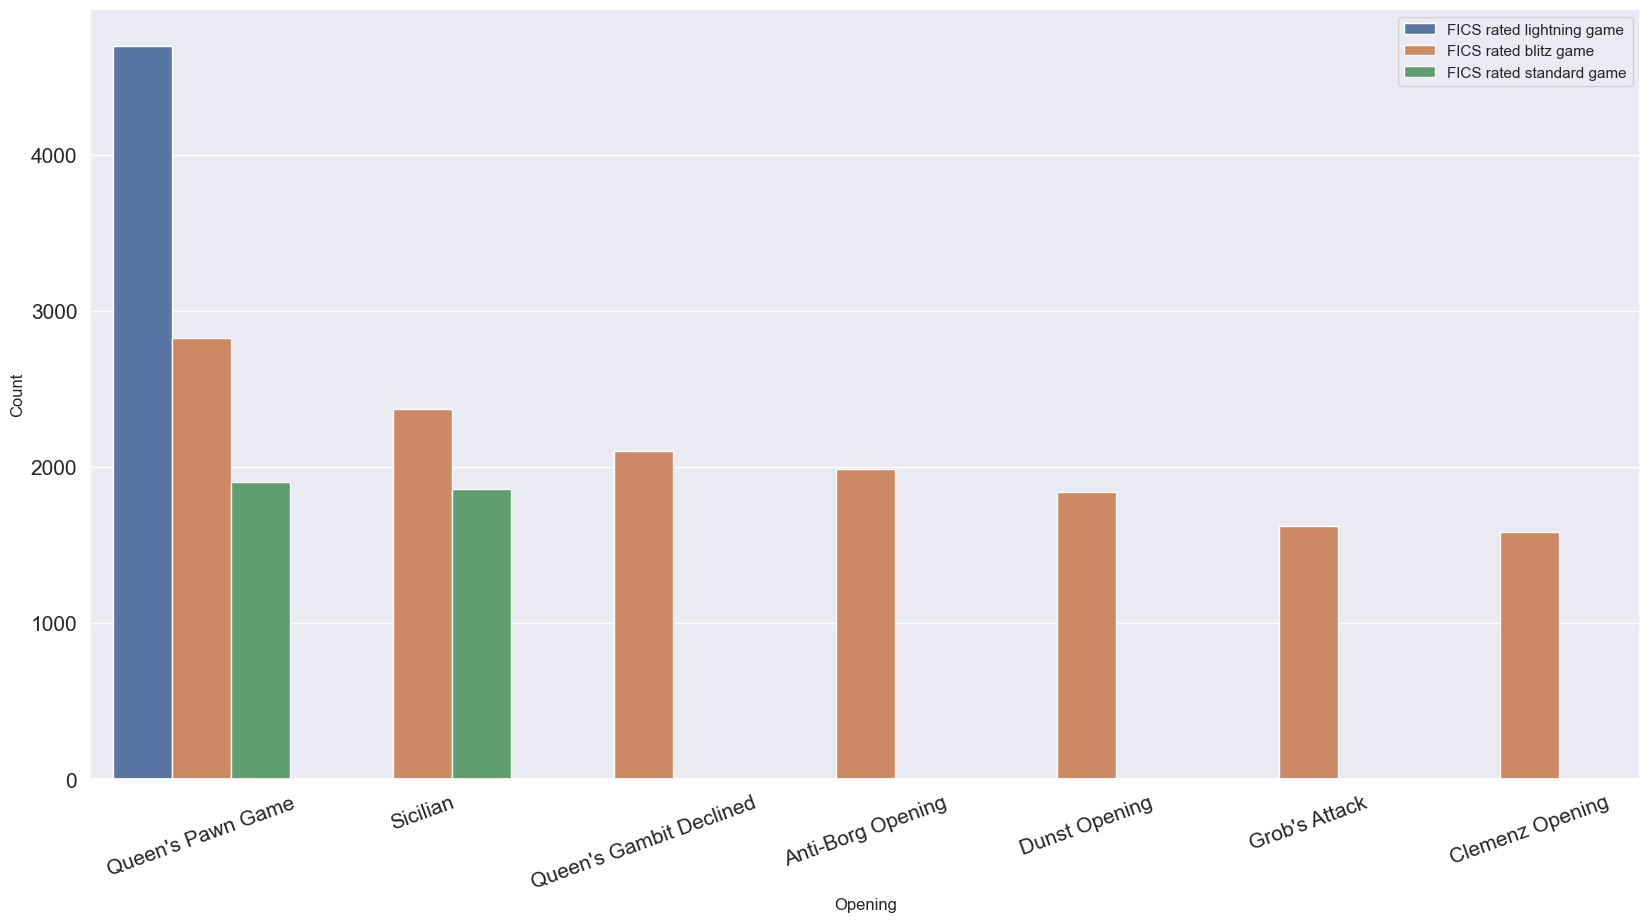

In [8]:
event_opening_count = data[['Event', 'ECO_Name']].value_counts()[
    :10].to_frame(name='Count').reset_index()

# Plot
sns.barplot(data=event_opening_count, x='ECO_Name', y='Count', hue='Event')

plt.legend(loc='upper right')
plt.xticks(fontsize=15, rotation=20)
plt.yticks(fontsize=15)
plt.xlabel('Opening')


### Is there a preferred opening for a player?

In [9]:
top_10_active_players = data[['White', 'Black']].melt(value_name='Player_Name').drop(
    columns='variable').value_counts()[:10].reset_index(name='Count')

# Dictionary with key:value pair being
# Player_Name : Dataframe of the Top 5 most played openings [Opening, Count]
player_openings = {}

for player in top_10_active_players.Player_Name:
    top_5_openings = data[(data.Black == player) | (data.White == player)].ECO_Name.value_counts()[
        :5].reset_index(name='Count').rename(columns={'index': 'Opening'})
    player_openings[player] = pd.DataFrame(top_5_openings)

# Take a look at the first entry
player_openings['Geforce']


,Opening,Count
0,Sicilian,1597
1,Queen's Gambit Declined,998
2,Giuoco Piano,755
3,Uncommon King's Pawn Opening,736
4,Dunst Opening,663


Text(0.5, 1.0, "Top 5 Openings for 'Geforce'")

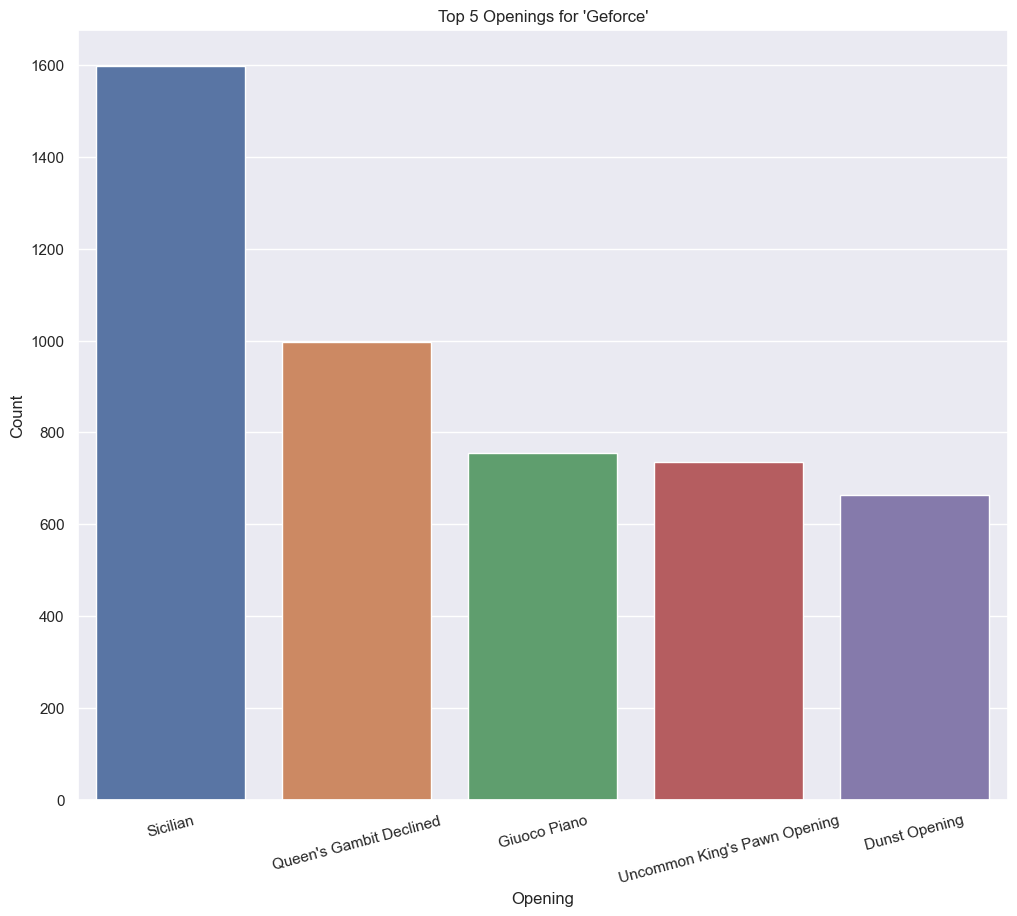

In [10]:
# Plot

sns.set(rc={"figure.figsize": (12, 10)})
sns.barplot(data=player_openings['Geforce'],
            x=player_openings['Geforce'].Opening, y=player_openings['Geforce'].Count)
plt.xticks(rotation=15)
plt.title('Top 5 Openings for \'Geforce\'')


### Is there a player/color combination that is most successful?

Text(0.5, 0, 'Player Name')

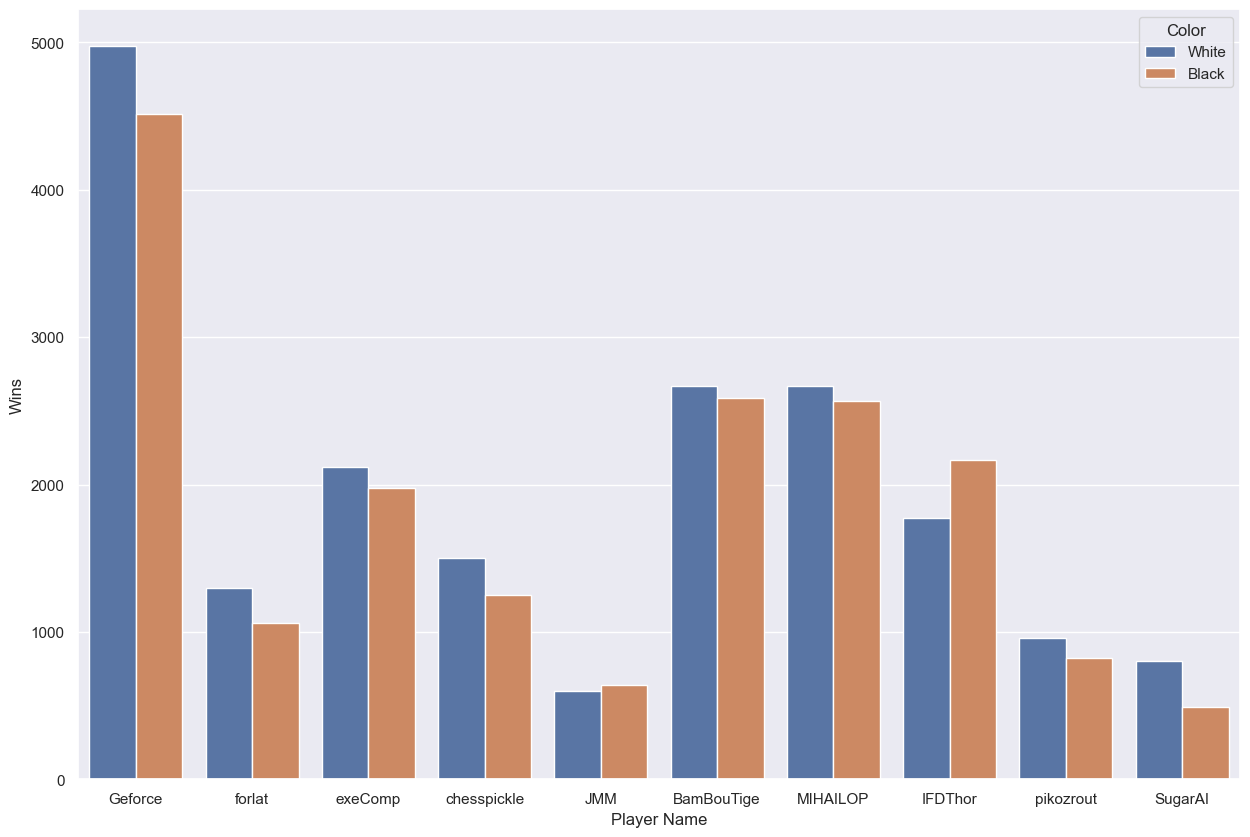

In [11]:
# The 'data.Result' column can be dropped fom the concatenated dataframe if need be.
data = pd.concat([data, pd.get_dummies(data.Result).rename(
    columns={'0-1': 'Black_Win', '1-0': 'White_Win', '1/2-1/2': 'Draw'})], axis=1)

# list to hold player color win dictionaries
p_c_combs = []

# we use the active player dataframe from above
for player in top_10_active_players.Player_Name:
    # get the dictionary for sum of wins with white
    p_c_w = {'Player_Name': player, 'Color': 'White',
             'Wins': data[(data.White == player)]['White_Win'].sum()}
    p_c_combs.append(p_c_w)

    # get the dictionary for sum of wins with black
    p_c_b = {'Player_Name': player, 'Color': 'Black',
             'Wins': data[(data.Black == player)]['Black_Win'].sum()}
    p_c_combs.append(p_c_b)

# Create a Dataframe with the list of dictionaries
p_c_df = pd.DataFrame(p_c_combs)

# Plot
sns.set(rc={"figure.figsize": (15, 10)})
sns.barplot(data=p_c_df, x='Player_Name', y='Wins', hue='Color')
plt.xlabel('Player Name')


### Which opening was played the most based on AVG ELO of the players in the game?

Text(0.5, 0, 'Openings for ELO 2200-2400')

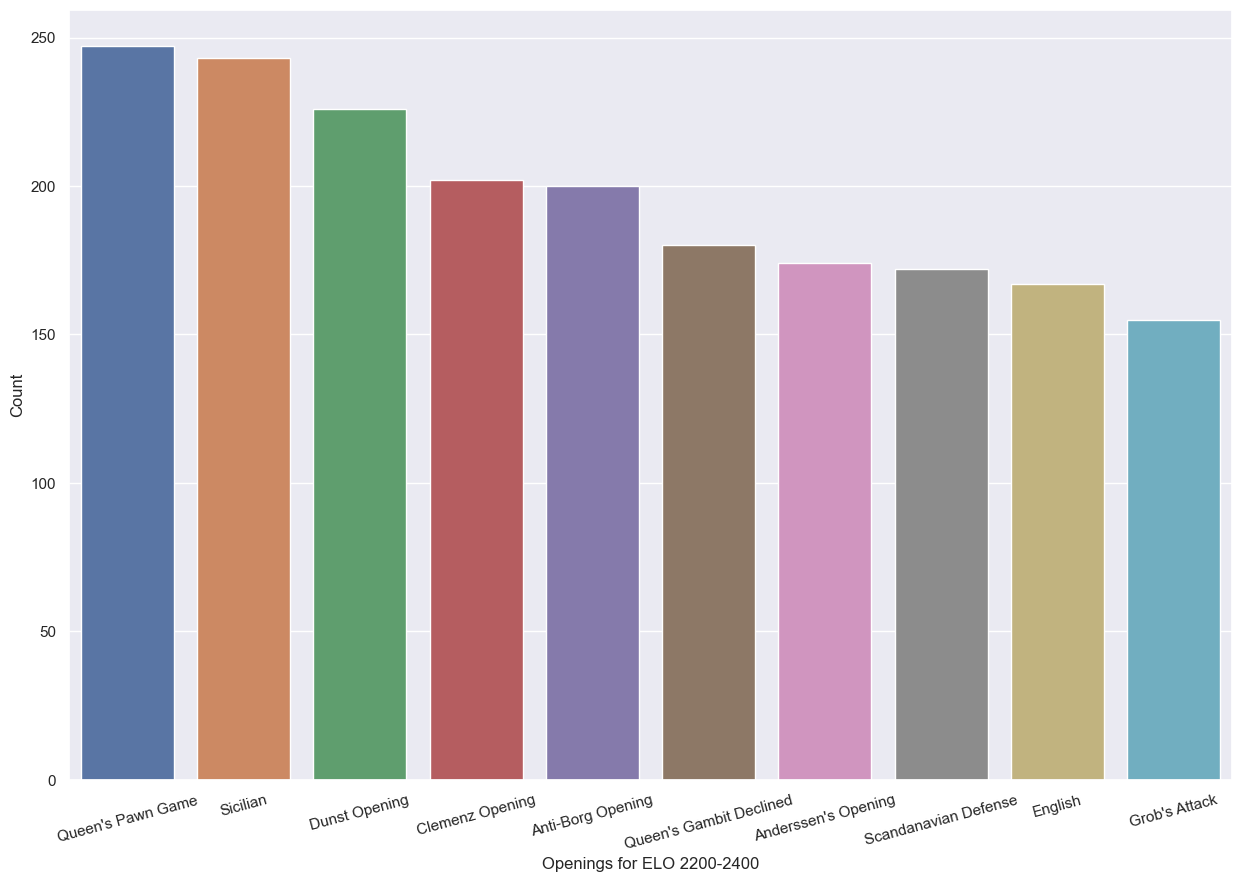

In [12]:
data['AvgElo'] = (data.WhiteElo + data.BlackElo) / 2
avg_elo_df = data[['AvgElo', 'ECO_Name']].value_counts().to_frame(
    name='Count').reset_index()

avg_elo_2000_2200_df = avg_elo_df[(avg_elo_df.AvgElo >= 2000) & (avg_elo_df.AvgElo < 2200)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]
avg_elo_2200_2400_df = avg_elo_df[(avg_elo_df.AvgElo >= 2200) & (avg_elo_df.AvgElo < 2400)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]
avg_elo_2400_2600_df = avg_elo_df[(avg_elo_df.AvgElo >= 2400) & (avg_elo_df.AvgElo < 2600)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]
avg_elo_2600_2800_df = avg_elo_df[(avg_elo_df.AvgElo >= 2600) & (avg_elo_df.AvgElo < 2800)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]
avg_elo_2800_3000_df = avg_elo_df[(avg_elo_df.AvgElo >= 2800) & (avg_elo_df.AvgElo < 3000)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]
avg_elo_3000_3500_df = avg_elo_df[(avg_elo_df.AvgElo >= 3000) & (avg_elo_df.AvgElo < 3500)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]

# Plot one of the dataframes
sns.barplot(x=avg_elo_2200_2400_df.ECO_Name, y=avg_elo_2200_2400_df.Count)
plt.xticks(rotation=15)
plt.xlabel('Openings for ELO 2200-2400')


### Is there a opening a player with a particular ELO should play to maximize the chance of winning?

In [13]:
# Create dataframe with only the required columns
predict_white_opening_df = data[['WhiteElo', 'White_Win', 'ECO_Name']].copy()

# Drop the rows where ECO_Name is a NaN
predict_white_opening_df.dropna(subset=['ECO_Name'], inplace=True)

# Create the features dataframe
predict_white_opening_df_X = predict_white_opening_df[['WhiteElo', 'ECO_Name']]

# Get the encoded columns for the ECO_Name
predict_white_opening_df_X = pd.concat([predict_white_opening_df_X, pd.get_dummies(
    predict_white_opening_df_X.ECO_Name)], axis=1)

# Drop the ECO_Name column
predict_white_opening_df_X.drop(columns='ECO_Name', inplace=True)

# Create the label dataframe
predict_white_opening_df_y = predict_white_opening_df.White_Win


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    predict_white_opening_df_X, predict_white_opening_df_y, test_size=0.2, random_state=42)


In [15]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

clf = make_pipeline(
    StandardScaler(), RandomForestClassifier(n_jobs=-1, verbose=3))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('accuracy score:', accuracy_score(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred, average='weighted'))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s


accuracy score: 0.6439499894045349
f1 score: 0.6437452915386747


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
